In [386]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from data.task4 import marker
from scipy.optimize import least_squares
%matplotlib inline

In [387]:
def show(imgs, titles=None, fig_rows=1, fig_cols=1, figsize=None, axis='off'):
    assert len(imgs) == fig_rows*fig_cols
    assert titles == None or len(titles) == len(imgs)
    plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(fig_rows, fig_cols, i+1)
        plt.axis(axis)
        if titles:
            plt.title(titles[i])
        plt.imshow(img)
    plt.show()

In [388]:
def calc_response_map(img, winsize):
    padded_img = np.pad(img, winsize//2, 'edge')
    derX = cv2.Scharr(padded_img, cv2.CV_32F, 1, 0)
    derY = cv2.Scharr(padded_img, cv2.CV_32F, 0, 1)
    derXX = np.square(derX)
    derXY = np.multiply(derX, derY)
    derYY = np.square(derY)
    
    resp_mat = np.zeros_like(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            A = np.zeros((2, 2))
            for ny in range(y, y + winsize):
                for nx in range(x, x+winsize):
                    A[0][0] += derXX[ny][nx]
                    A[0][1] += derXY[ny][nx]
                    A[1][1] += derYY[ny][nx]
            A[1][0] = A[0][1]
            eigs = np.linalg.eigvals(A)
            resp_mat[y][x] = np.min(eigs)
    return resp_mat

In [389]:
def non_max_suppress(img, winsize):
    padded_img = np.pad(img, winsize//2, 'constant')
    res_img = img.copy()
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for ny in range(y, y+winsize):
                for nx in range(x, x+winsize):
                    if img[y][x] < padded_img[ny][nx]:
                        res_img[y][x] = 0
                        break
    return res_img

In [390]:
def draw_circles(img, points):
    result_img = img.copy()
    ys, xs = points
    for i in range(len(ys)):
        cv2.circle(result_img, (xs[i], ys[i]), 5, (0, 0, 255), 1, cv2.LINE_AA)
    return result_img

In [391]:
from math import log

def calc_symmetry_heat_map(img, winsize=7):
    delta = winsize//2
    padded_img = np.pad(img, delta, 'edge')
    derX = cv2.Scharr(padded_img, cv2.CV_32F, 1, 0)
    derY = cv2.Scharr(padded_img, cv2.CV_32F, 0, 1)
    der = np.array([[[derX[y][x], derY[y][x]] for x in range(derX.shape[1])] for y in range(derX.shape[0])])
    
    heat_map = np.zeros_like(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for dy in range(1, delta+1):
                for dx in range(-delta, delta+1):
                    heat_map[y][x] -= np.dot(der[y+delta-dy][x+delta-dx], der[y+delta+dy][x+delta+dx])
            for dx in range(1, winsize//2+1):
                heat_map[y][x] -= np.dot(der[y+delta][x+delta-dx], der[y+delta][x+delta+dx])
    
    return heat_map

In [392]:
a = np.array([[5, 4], [3, 0], [3, 4], [4, 0]])
ind = np.lexsort(np.transpose(a))
ind
#a[ind]

array([1, 3, 2, 0])

In [393]:
def find_points(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)
    # response map
    resp_mat = calc_response_map(img_gray, winsize=3)
    # non-maximum suppression
    suppressed = non_max_suppress(resp_mat, winsize=7)
    # visualisation
    show([resp_mat, suppressed], ['Карта отклика', 'Non-maximum suppression'], figsize=(10, 5), fig_cols=2)
    
    # symmetry heat map
    sym_heat_map = calc_symmetry_heat_map(img_gray, winsize=7)       
    # non-maximum suppression
    sym_suppressed = non_max_suppress(sym_heat_map, winsize=7)
    # visualisation
    show([sym_heat_map, sym_suppressed], ['Карта отклика симметрии', 'Non-maximum suppression'], figsize=(10, 5), fig_cols=2)
    
    # response + symmetry
    combo_map = (resp_mat/np.max(resp_mat)) + (sym_heat_map/np.max(sym_heat_map))
    # non-maximum suppression
    combo_suppressed = non_max_suppress(combo_map, winsize=7)
    # visualisation
    show([combo_map, combo_suppressed], ['Карта отклика комбо', 'Non-maximum suppression'], figsize=(10, 5), fig_cols=2)
    
    # thresholding
    threshold = np.sort(suppressed.flatten())[-9]
    result_img = draw_circles(img, np.nonzero(suppressed >= threshold))
    sym_threshold = np.sort(sym_suppressed.flatten())[-9]
    sym_result_img = draw_circles(img, np.nonzero(sym_suppressed >= sym_threshold))
    combo_threshold = np.sort(combo_suppressed.flatten())[-9]
    combo_result_img = draw_circles(img, np.nonzero(combo_suppressed >= combo_threshold))
    
    show([result_img, sym_result_img, combo_result_img], 
         ['Отбор лучших 9 точек', 'Отбор лучших 9 точек по симметрии', 'Отбор лучших 9 точек комбо'],
         figsize=(15, 10), fig_cols=3)
    
    ys, xs = np.nonzero(combo_suppressed >= combo_threshold)
    points = list(zip(xs, ys))
    
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    points = cv2.cornerSubPix(img_gray,np.float32(points),(5,5),(-1,-1),criteria)
    
    return points

In [394]:
def error(coeffs, model, points, cameraMatrix):
    print(coeffs)
    proj, _ = cv2.projectPoints(model, coeffs[:3], coeffs[3:], cameraMatrix, 0)
    print(proj)
    er = [cv2.norm(proj[i][0] - points[i], cv2.NORM_L2) for i in range(9)]
    print('Error: {}'.format(er))
    return er

In [395]:
def sort_points(points):
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            if points[i][0] > points[j][0] or (points[i][0]==points[j][0] and points[i][1]>points[j][1]):
                temp = points[i].copy()
                points[i] = points[j]
                points[j] = temp

In [396]:
def handle(filename):
    print(filename)
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    roi = img[marker.ry:marker.ry+marker.rh, marker.rx:marker.rx+marker.rw].copy()
    
    cv2.rectangle(img, (marker.rx, marker.ry), (marker.rx+marker.rw, marker.ry+marker.rh), (0, 255, 0), 2)
    show([img], titles=['Исходное изображение'], figsize=(10, 8))
    
    points = find_points(roi)
    print(points)
    sort_points(points)
    print(points)
    
    
    K = np.array([[marker.fx, 0, marker.cx],
                  [0, marker.fy, marker.cy],
                  [0, 0, 1]])
    M = np.array([[x*marker.markerWidth, y*marker.markerHeight, 1] for x in range(3) for y in range(3)])
    jac = lambda coeffs, M, points, K: cv2.projectPoints(M, coeffs[:3], coeffs[3:], K, 0)[1][:9, :6]
    least_squares(error, [0, 0, 0, 0, 0, 0], method='lm', args=(M, points, K), jac=jac)

./data/task4/marker1.jpg


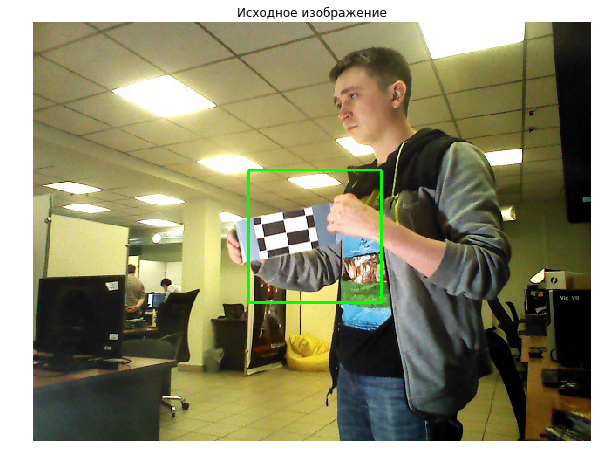

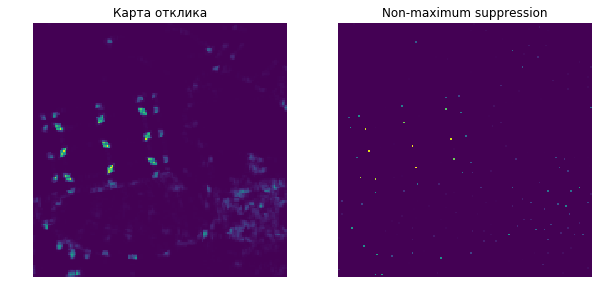

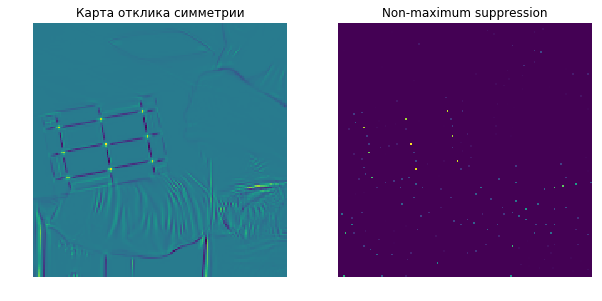

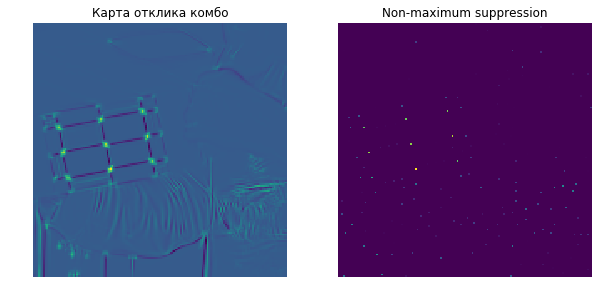

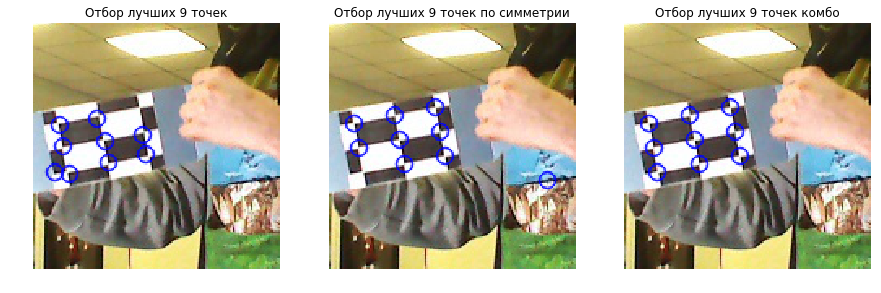

[[ 64.96264648  52.42045212]
 [ 40.07468796  57.13147736]
 [ 14.73266983  61.79960632]
 [ 67.89207458  67.35810852]
 [ 42.859375    72.22564697]
 [ 17.56324577  77.08229065]
 [ 70.72393036  82.27469635]
 [ 45.68511963  87.17803192]
 [ 20.49572372  92.04284668]]
[[ 14.73266983  61.79960632]
 [ 17.56324577  77.08229065]
 [ 20.49572372  92.04284668]
 [ 40.07468796  57.13147736]
 [ 42.859375    72.22564697]
 [ 45.68511963  87.17803192]
 [ 64.96264648  52.42045212]
 [ 67.89207458  67.35810852]
 [ 70.72393036  82.27469635]]
[ 0.  0.  0.  0.  0.  0.]
[[[   320.      240.  ]]

 [[   320.    18086.7 ]]

 [[   320.    35933.4 ]]

 [[ 30544.25    240.  ]]

 [[ 30544.25  18086.7 ]]

 [[ 30544.25  35933.4 ]]

 [[ 60768.5     240.  ]]

 [[ 60768.5   18086.7 ]]

 [[ 60768.5   35933.4 ]]]
Error: [353.47351127839056, 18012.156950994555, 35842.60851840129, 30504.72344349939, 35423.94834394831, 47064.99855675093, 60703.8271719045, 63318.721439373585, 70494.84523948049]
[ 0.  0.  0.  0.  0.  0.]
[[[   320

In [397]:
for i in range(0, 5, 1):
    if not i in [0, 15, 18, 19]:
        handle('./data/task4/marker{}.jpg'.format(i))
        break

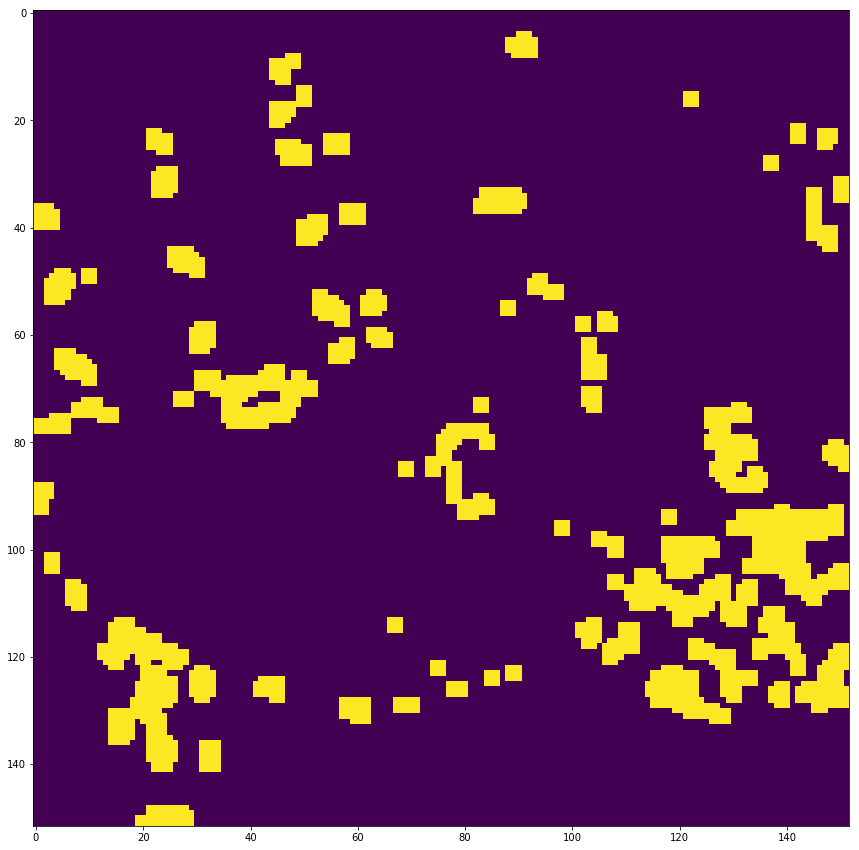

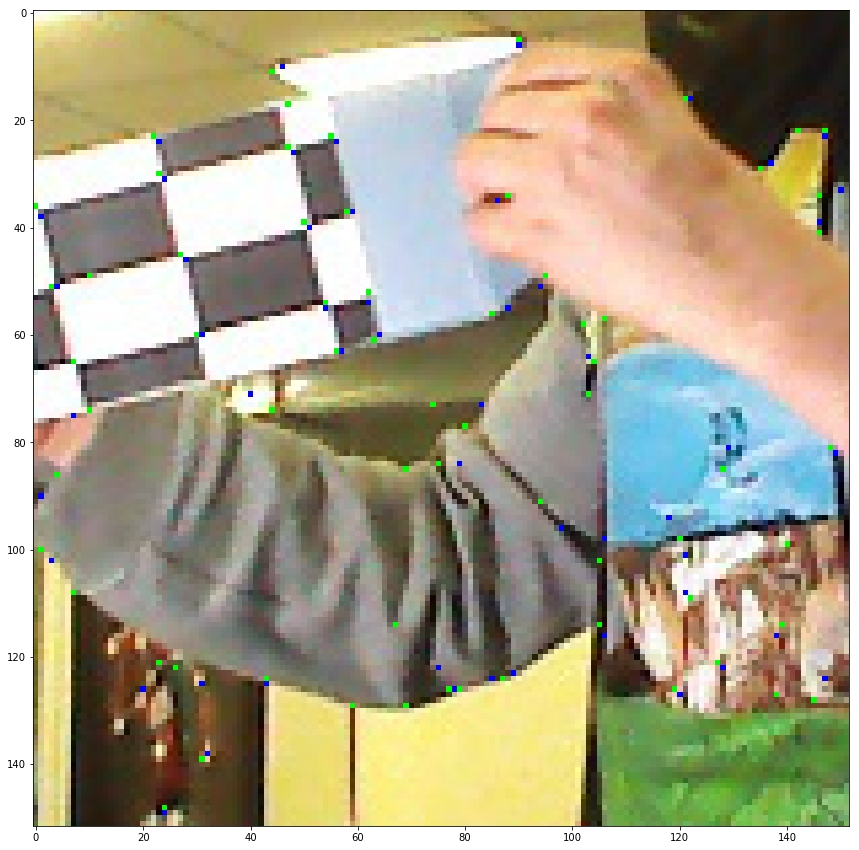

In [398]:
#filename = '../data/chessboard_s.png'
#filename = '../data/chessboard_shear.png'
#filename = '../data/chessboard_transform.png'
filename = './data/task4/marker0.jpg'
img = cv2.imread(filename)
img = img[marker.ry:marker.ry+marker.rh, marker.rx:marker.rx+marker.rw].copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)
plt.figure(figsize=(20, 15))
plt.imshow(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

#cv2.imwrite('subpixel5.png',img)
plt.figure(figsize=(20, 15))
plt.imshow(img)